In [1]:
df = pd.DataFrame(io.l1b_filenames('inbound*v02_s08', iterator=False), columns=['fname'])
df.size

21

In [2]:
import os
df['basename'] = df.fname.map(os.path.basename)

In [3]:
df.columns

Index(['fname', 'basename'], dtype='object')

In [4]:
# removing echelle for now
df = df[~df.basename.str.contains('-ech')]
# then focusing on FUV data
df = df[df.basename.str.contains('-fuv_')]
# remove data with mode3001
df = df[~df.basename.str.contains('-mode3001-')]

In [5]:
df.basename.size

21

In [6]:
%matplotlib inline

In [7]:
def calc_4_to_3(width):
    return width, width*3/4
plt.style.use('bmh')
plt.rcParams['figure.figsize']= calc_4_to_3(9)
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['lines.linewidth'] = 1
plt.ioff()

In [52]:
l1b = io.L1BReader(df.fname.iloc[2])

In [55]:
df.fname.iloc[2]

'/maven_iuvs/stage/products/level1b/mvn_iuv_l1b_inbound-orbit00109-fuv_20141018T193419_v02_s08.fits.gz'

In [53]:
l1b.dark_times

0   2014-10-18 15:53:52.003491
1   2014-10-19 00:11:03.037275
dtype: datetime64[ns]

In [56]:
import os
for fname in df.fname:
    l1b = io.L1BReader(fname)
    print(os.path.basename(fname))
    print(l1b.dark_times)

mvn_iuv_l1b_inbound-orbit00107-fuv_20141018T102014_v02_s08.fits.gz
0   2014-10-18 07:36:59.067504
1   2014-10-18 14:56:59.005275
dtype: datetime64[ns]
mvn_iuv_l1b_inbound-orbit00108-fuv_20141018T145717_v02_s08.fits.gz
0   2014-10-18 11:16:49.011939
1   2014-10-18 19:34:00.096826
dtype: datetime64[ns]
mvn_iuv_l1b_inbound-orbit00109-fuv_20141018T193419_v02_s08.fits.gz
0   2014-10-18 15:53:52.003491
1   2014-10-19 00:11:03.037275
dtype: datetime64[ns]
mvn_iuv_l1b_inbound-orbit00110-fuv_20141019T001122_v02_s08.fits.gz
0   2014-10-18 20:30:53.095042
1   2014-10-19 04:48:05.028328
dtype: datetime64[ns]
mvn_iuv_l1b_inbound-orbit00111-fuv_20141019T044824_v02_s08.fits.gz
0   2014-10-19 01:07:56.035990
1   2014-10-19 09:25:09.019380
dtype: datetime64[ns]
mvn_iuv_l1b_inbound-orbit00112-fuv_20141019T092528_v02_s08.fits.gz
0   2014-10-19 05:44:59.076647
1   2014-10-19 14:02:11.085484
dtype: datetime64[ns]
mvn_iuv_l1b_inbound-orbit00113-fuv_20141019T140231_v02_s08.fits.gz
0   2014-10-19 10:22:03.017

In [61]:
l1b.Integration.loc['UTC']

0      2015/085 Mar 26 17:45:19.96275UTC
1      2015/085 Mar 26 17:45:34.96276UTC
2      2015/085 Mar 26 17:45:49.96277UTC
3      2015/085 Mar 26 17:46:04.96278UTC
4      2015/085 Mar 26 17:46:19.96279UTC
5      2015/085 Mar 26 17:46:34.96280UTC
6      2015/085 Mar 26 17:46:49.96281UTC
7      2015/085 Mar 26 17:47:04.96282UTC
8      2015/085 Mar 26 17:47:19.96283UTC
9      2015/085 Mar 26 17:47:34.96284UTC
10     2015/085 Mar 26 17:47:49.96285UTC
11     2015/085 Mar 26 17:48:04.96286UTC
12     2015/085 Mar 26 17:48:19.96287UTC
13     2015/085 Mar 26 17:48:34.96288UTC
14     2015/085 Mar 26 17:48:49.96289UTC
15     2015/085 Mar 26 17:49:04.96290UTC
16     2015/085 Mar 26 17:49:19.96291UTC
17     2015/085 Mar 26 17:49:34.96292UTC
18     2015/085 Mar 26 17:49:49.96293UTC
19     2015/085 Mar 26 17:50:04.96293UTC
20     2015/085 Mar 26 17:50:19.96294UTC
21     2015/085 Mar 26 17:50:34.96295UTC
22     2015/085 Mar 26 17:50:49.96296UTC
23     2015/085 Mar 26 17:51:04.96297UTC
24     2015/085 

In [9]:
l1b.dark_det_temps

array([-16.3158, -15.9413])

In [10]:
def get_dark_data(fname):
    from iuvs import io
    l1b = io.L1BReader(fname)
    return fname, l1b.dark_times, l1b.n_darks, l1b.dark_det_temps

In [11]:
from IPython.parallel import Client
c = Client()
lbview = c.load_balanced_view()

In [12]:
results = lbview.map_async(get_dark_data, df.fname)

In [13]:
from iuvs import multitools as mt

In [14]:
mt.progress_display(results, df.fname)

42.9 % done.


In [15]:
results = pd.DataFrame(results.result, columns=['fname','times','n_darks', 'dark_det_temps'])

In [16]:
results['timedelta_max'] = results.times.map(lambda x: x.diff().max())

In [17]:
results.head()

,fname,times,n_darks,dark_det_temps,timedelta_max
0,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,0 2014-10-18 11:16:49.011939 1 2014-10-18 ...,2,"[-16.3158, -15.9413]",08:17:11.084887
1,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,0 2015-03-26 14:59:56.076953 1 2015-03-26 ...,2,"[-18.6377, -18.5628]",00:00:15.000001
2,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,0 2014-10-18 20:30:53.095042 1 2014-10-19 ...,2,"[-16.5405, -15.9413]",08:17:11.933286
3,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,0 2014-10-22 03:00:04.053989 1 2014-10-22 ...,2,"[-16.3907, -15.5668]",08:17:11.034284
4,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,0 2014-10-18 15:53:52.003491 1 2014-10-19 ...,2,"[-16.2409, -15.9413]",08:17:11.033784


In [18]:
pd.Timedelta(results.timedelta_max)

ValueError: Value must be Timedelta, string, integer, float, timedelta or convertible

In [19]:
%matplotlib nbagg

<IPython.core.display.Javascript object>


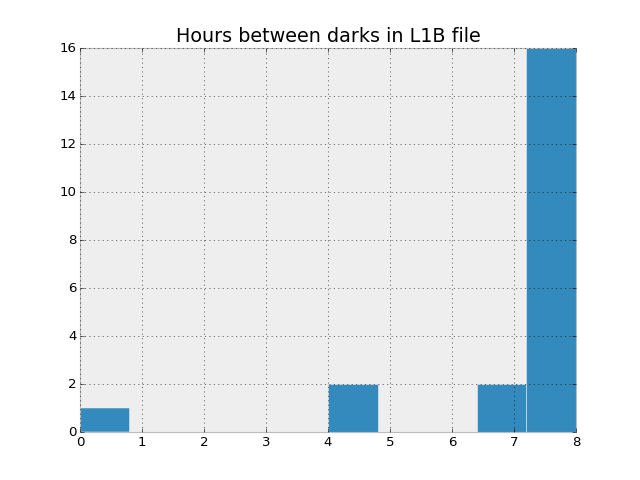

In [20]:
results.timedelta_max.dt.components.hours.hist()
plt.gca().set_title('Hours between darks in L1B file')

In [21]:
df = df.merge(results, on='fname')

In [22]:
df.n_darks.value_counts()

2    21
dtype: int64

In [23]:
df = df.sort('basename')

In [24]:
df.head()

,fname,basename,times,n_darks,dark_det_temps,timedelta_max
16,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,mvn_iuv_l1b_inbound-orbit00107-fuv_20141018T10...,0 2014-10-18 07:36:59.067504 1 2014-10-18 ...,2,"[-14.0688, -16.0162]",07:19:59.937771
0,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,mvn_iuv_l1b_inbound-orbit00108-fuv_20141018T14...,0 2014-10-18 11:16:49.011939 1 2014-10-18 ...,2,"[-16.3158, -15.9413]",08:17:11.084887
4,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,mvn_iuv_l1b_inbound-orbit00109-fuv_20141018T19...,0 2014-10-18 15:53:52.003491 1 2014-10-19 ...,2,"[-16.2409, -15.9413]",08:17:11.033784
2,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,mvn_iuv_l1b_inbound-orbit00110-fuv_20141019T00...,0 2014-10-18 20:30:53.095042 1 2014-10-19 ...,2,"[-16.5405, -15.9413]",08:17:11.933286
7,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,mvn_iuv_l1b_inbound-orbit00111-fuv_20141019T04...,0 2014-10-19 01:07:56.035990 1 2014-10-19 ...,2,"[-16.3158, -15.9413]",08:17:12.983390


In [25]:
l1b = io.L1BReader(df.fname.iloc[0])

In [26]:
fitter = scaling.DarkFitter(l1b, raw_integration=0, dark_integration=0)

In [27]:
parameters = []
for scaler in fitter.scalers:
    parameters.append(scaler.p)

In [28]:
parameters

[array([ 0.07720505]),
 [1.1556215348176488],
 array([ 0.97839107,  0.08792541]),
 array([ 3.99836912, -3.32085041,  1.21434882])]

<IPython.core.display.Javascript object>


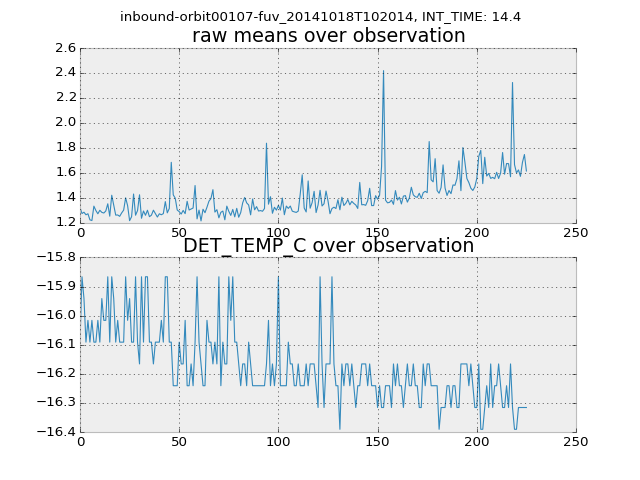

In [29]:
fig, ax = plt.subplots(2)
ax[0].plot(l1b.raw_dn_s.mean(axis=(1,2)), label='mean_raw')
ax[0].set_title('raw means over observation')
ax[1].plot(l1b.Integration.T.DET_TEMP_C)
ax[1].set_title('DET_TEMP_C over observation')
fig.suptitle(l1b.plottitle)
fig.savefig('/home/klay6683/plots/inbound_obs_T_and_mean_profile.png',dpi=120)

In [30]:
fitter = scaling.DarkFitter(l1b, raw_integration=0, dark_integration=0)

In [31]:
def process_fname(fname):
    from iuvs import scaling
    fitter = scaling.DarkFitter(fname, raw_integration=0, dark_integration=0)
    params = [scaler.p for scaler in fitter.scalers]
    add = params[0][0]
    mult = params[1][0]
    poly1_0, poly1_1 = params[2]
    poly2_0, poly2_1, poly2_2 = params[3]
    return fname, add, mult, poly1_0, poly1_1, poly2_0, poly2_1, poly2_2, fitter.l1b.dark_det_temps

In [32]:
results = lbview.map_async(process_fname, df.fname)

In [33]:
from iuvs import multitools

In [34]:
multitools.progress_display(results, df.fname)

0.0 % done.


In [35]:
resultsdf = pd.DataFrame(results.result, 
                         columns=['fname']+'add mult poly1_0 poly1_1 poly2_0 poly2_1 poly2_2 dark_det_temps'.split())

In [36]:
resultsdf.head()

,fname,add,mult,poly1_0,poly1_1,poly2_0,poly2_1,poly2_2,dark_det_temps
0,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,0.077205,1.155622,0.978391,0.087925,3.998369,-3.320850,1.214349,"[-14.0688, -16.0162]"
1,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,0.209291,1.535378,0.949768,0.228928,1.866362,-0.832732,0.625900,"[-16.3158, -15.9413]"
2,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,0.134166,1.339214,0.581727,0.299603,0.699709,-0.017181,0.423531,"[-16.2409, -15.9413]"
3,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,0.143451,1.355471,1.215124,0.056638,1.779658,-0.518925,0.453923,"[-16.5405, -15.9413]"
4,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,0.259398,1.665989,0.754978,0.354832,15.002240,-11.119888,2.662066,"[-16.3158, -15.9413]"


In [37]:
resultsdf['det_temps_mean']  = resultsdf.dark_det_temps.map(lambda x: x.mean())

In [38]:
resultsdf['det_temps_std'] = resultsdf.dark_det_temps.map(lambda x: x.std())

In [39]:
resultsdf.head()

,fname,add,mult,poly1_0,poly1_1,poly2_0,poly2_1,poly2_2,dark_det_temps,det_temps_mean,det_temps_std
0,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,0.077205,1.155622,0.978391,0.087925,3.998369,-3.320850,1.214349,"[-14.0688, -16.0162]",-15.04250,0.97370
1,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,0.209291,1.535378,0.949768,0.228928,1.866362,-0.832732,0.625900,"[-16.3158, -15.9413]",-16.12855,0.18725
2,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,0.134166,1.339214,0.581727,0.299603,0.699709,-0.017181,0.423531,"[-16.2409, -15.9413]",-16.09110,0.14980
3,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,0.143451,1.355471,1.215124,0.056638,1.779658,-0.518925,0.453923,"[-16.5405, -15.9413]",-16.24090,0.29960
4,/maven_iuvs/stage/products/level1b/mvn_iuv_l1b...,0.259398,1.665989,0.754978,0.354832,15.002240,-11.119888,2.662066,"[-16.3158, -15.9413]",-16.12855,0.18725


In [40]:
%matplotlib inline

In [41]:
import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

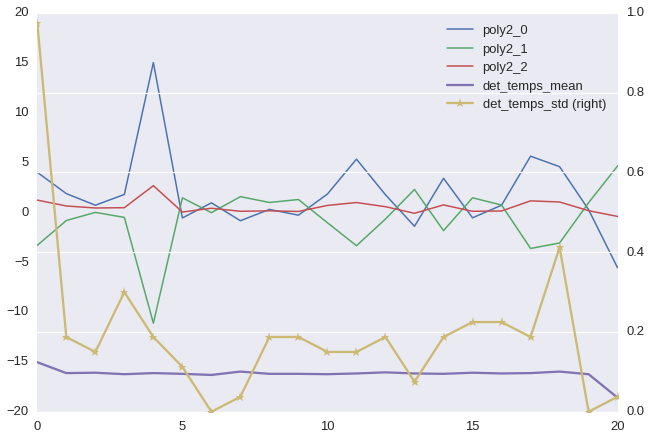

In [42]:
resultsdf.filter(regex='poly2_').plot(lw=1.5)
resultsdf.det_temps_mean.plot(legend=True)
resultsdf.det_temps_std.plot(secondary_y=True, style='*-', legend=True)
plt.savefig('/home/klay6683/plots/poly2_all_inbounds.png',dpi=120)

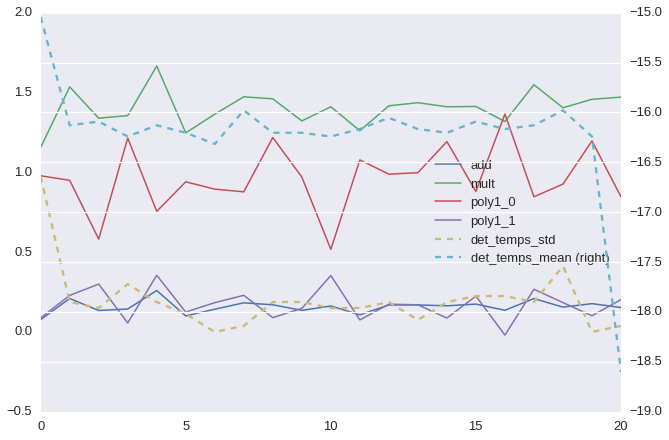

In [43]:
resultsdf['add mult poly1_0 poly1_1'.split()].plot(lw=1.5)
resultsdf.det_temps_std.plot(legend=True, style='--')
resultsdf.det_temps_mean.plot(legend=True, style='--',secondary_y=True)
plt.savefig('/home/klay6683/plots/all_other_params_over_inbound.png', dpi=120)